# Error study

In this file I study the error of the algorithm. Since there is a big error coming from the thermalization it makes no sense to be extremely precise in the subsequent TEBD. What I require is to have the maximum error to be less than 0.1% and get the right values for the tolerance and cutoff.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import random

import quimb as qu
import quimb.tensor as qtn
import quimb.linalg.base_linalg as la
from itertools import product, cycle

In [2]:
### PROBLEM PARAMETERS
L = 7         # chain length
omega = 1     # Rabi frequency
V = 1         # B-S interaction strength
V_ = 1        # bath interaction strength
beta = 1      # inverse temperature for the bath

T = 5          # total time of the simulation
dt = 0.01      # time step for coherece vector time evolution

tolerance = 1e-3 # Trotter
cutoff = 1e-8 # cutoff for TEBD algorithm

### USEFULL VARIABLES
dims = [2]*L # overall space of L qbits

I = qu.pauli('I')
X = qu.pauli('X')
Z = qu.pauli('Z')

In [2]:
def calculate_error(L, omega, V, V_, beta, T, dt, re_cutoff, img_cutoff, tolerance):
    ### BUILDING THE HAMILTONIAN
    
    dims = [2]*L # overall space of L qbits

    I = qu.pauli('I')
    X = qu.pauli('X')
    Z = qu.pauli('Z')
    # fisrt I build the operators
    nn_op = (I + Z)/2 & (I + Z)/2

    print(f'Building Hamiltonian for L={L}')
    # the hamiltonian
    H_Rabi = sum(qu.ikron(X, dims, i) for i in range(L))
    H_int_b = sum(qu.ikron(nn_op, dims, (i, i+1)) for i in range(2, L-1))
    H_int_s = sum(qu.pkron(nn_op, dims, (i, j)) for i,j in zip([L-1,0,1], [0,1,2]))

    H = (omega/2)*H_Rabi + V_*H_int_b + V*H_int_s

    # diagonalization
    e, U = la.eig(H, isherm=True)

    #print('done :)')
    
    ### BUILDING THE OBSERVABLES

    observables_ex = {}
    results_ex = {}
    for ob1, ob2 in product(['I', 'X', 'Y', 'Z'], repeat=2):
        key = ob1 + '1' + ob2 + '2'
        results_ex[key] = []
        observables_ex[key] = qu.ikron(qu.pauli(ob1)&qu.pauli(ob2), dims, (0, 1))

    # dropping the identity
    observables_ex.pop('I1I2')
    results_ex.pop('I1I2')


    ### INITIAL CONDITIONS
    print('Initial state: random subsystem and thermal bath\n')

    #rho = la.expm(-beta*H)
    #rho /= rho.trace()

    rho = qu.gen.states.thermal_state(H, beta)

    # apply a random operator to the first two spins
    rand1 = qu.gen.rand.rand_uni(2)
    rand2 = qu.gen.rand.rand_uni(2)
    U_rand = qu.ikron(rand1 & rand2, dims, (0, 1))
    rho = U_rand @ rho @ U_rand.H

    ### THE SIMULATION

    # smarter way to calculate the coherence vector:
    rho_tilde = np.conj(U.T) @ rho @ U    

    pauli_tilde = {}
    t = []
    for key in observables_ex.keys():
        pauli_tilde[key] = np.conj(U.T) @ observables_ex[key] @ U

    for i in range(0, int(T/dt)):
        ee = np.exp(-1j*e*dt*i)  # diagonalized hamiltonian
        rho_in = ee.reshape(ee.shape[0],1)*rho_tilde*np.conj(ee)

        trace = lambda key: ( (pauli_tilde[key]@rho_in).trace() / rho_tilde.trace()).real
        for key in results_ex.keys():
            results_ex[key].append(trace(key))

        t.append( dt*i )

    #print("finished Time = %s" % T)

    print('done')
    
    ### BUILDING THE HAMILTONIAN for the thermalization

    O_Rabi = (omega/2)*X & I
    N = (I + Z)/2 & I

    print(f'Building Hamiltonian for L={L} \n')
    # the hamiltonian
    H1 = {i: O_Rabi for i in range(L)}
    H2 = {None: V_*N&N, (L-1, 0): V*N&N, (0, 1): V*N&N, (1, 2): V*N&N}

    H = qtn.LocalHam1D(L=L, H2=H2, H1=H1, cyclic=True)

    ### BUILDING THE SPIN CHAIN

    print('Building the spin chain \n')
    B = np.array([1, 0, 0, 1])/np.sqrt(2)
    arrays = [B for i in range(L)]

    psi = qtn.MPS_product_state(arrays, cyclic=True)#, site_ind_id='s{}')

    #psi.show()
    
    ### IMAGINARY TIME EVOLUTION

    print('Imaginary time evolution \n')

    # create the object
    tebd_th = qtn.TEBD(psi, H, imag=True)

    # cutoff for truncating after each infinitesimal-time operator application
    tebd_th.split_opts['cutoff'] = img_cutoff

    tebd_th.update_to(beta/2, tol=tolerance)
    psi_th = tebd_th.pt / tebd_th.pt.norm()
    
    ### INITIAL CONDITIONS

    # random initial conditions
    Rand1 = rand1 & qu.pauli('I')
    Rand2 = rand2 & qu.pauli('I')

    psi_init = psi_th.gate(Rand1&Rand2, (0,1), contract='swap+split')

    ### THE SIMULATION
    
    print('Real time evolution')
    start = time.time()

    # first I build the observables
    observables_tebd = {}
    results_tebd = {}
    for ob1, ob2 in product(['I', 'X', 'Y', 'Z'], repeat=2):
        key = ob1 + '1' + ob2 + '2'
        results_tebd[key] = []
        observables_tebd[key] = []

    # dropping the identity
    observables_tebd.pop('I1I2')
    results_tebd.pop('I1I2')

    # create the object
    tebd = qtn.TEBD(psi_init, H)

    # cutoff for truncating after each infinitesimal-time operator application
    tebd.split_opts['cutoff'] = re_cutoff

    keys = results_tebd.keys()

    # I can either set a timestep or a tolerance and the timestep is calculated accordingly
    # generate the state at each time in t (same as exact simulation)
    #     and target error 1e-3 for whole evolution
    for psit in tebd.at_times(t, tol=tolerance):
        for key in keys:
            ob1 = qu.pauli(key[0]) & qu.pauli('I')
            ob2 = qu.pauli(key[2]) & qu.pauli('I')
            results_tebd[key].append((psit.H @ psit.gate(ob1 & ob2, (0, 1))).real)

    end = time.time()
    print(f'Time:{int(end - start)}s')
    
    # PLOT
    t = np.arange(0, T, dt)

    rows= 5
    columns = 3

    fig, axs = plt.subplots(rows, columns, figsize=(15,15), dpi=80)
    plt.setp(axs, xlim=(0,T), ylim=(-0.5, 0.5))
    
    keys = list(keys)
    for i in range(rows):
        for j in range(columns):
            #if i == rows-1 & j == columns-1:
            #    continue
            axs[i, j].plot(t, results_tebd[keys[(columns-1)*i+j]], label='TEBD', color='k')
            axs[i, j].plot(t, results_ex[keys[(columns-1)*i+j]], label='ex', color='r', linestyle='--')
            axs[i, j].grid()
    axs[4, 2].grid()
    #plt.legend()
    plt.grid()

    fig = plt.gcf()
    plt.show()
    
    ### PLOT & MAX ERROR

    line_styles = ['-', '-', '-', '-', ':', '--', '--', '-', '--', ':', '--', '-', '--', '--', ':']
    stylescicler = cycle(line_styles)
    line_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:blue', 'tab:blue', 'tab:orange', \
                   'tab:purple', 'tab:green', 'tab:orange', 'tab:red', 'tab:pink', 'tab:purple', 'tab:pink',\
                   'tab:green']
    colorscicler = cycle(line_colors)

    keys = observables_tebd.keys()

    diff = {}

    plt.figure(dpi=130)

    norm = []
    for i in range(len(t)):
        norm.append(np.linalg.norm(np.array([results_ex[key][i] for key in keys])))
        
    max_err = 0
    for key in keys:
        diff[key] = [abs(results_ex[key][i] - results_tebd[key][i])/norm[i] for i in range(len(t))]
        max_err = max(max_err, max(diff[key]))
        plt.plot(t, diff[key], linewidth=1, label=key, linestyle=next(stylescicler), color=next(colorscicler))

    plt.grid()
    plt.xlabel(r't/$\Omega$')
    plt.title('Exact - TEBD')

    fig = plt.gcf()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    return max_err

Building Hamiltonian for L=8
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=8 

Building the spin chain 

Imaginary time evolution 



t=0.5, max-bond=35: 100%|###################################################################################################################################| 100/100 [00:00<00:00, 182.11%/s]


Real time evolution


t=4.99, max-bond=48: 100%|##################################################################################################################################| 500/500 [01:41<00:00,  4.91it/s]


Time:101s


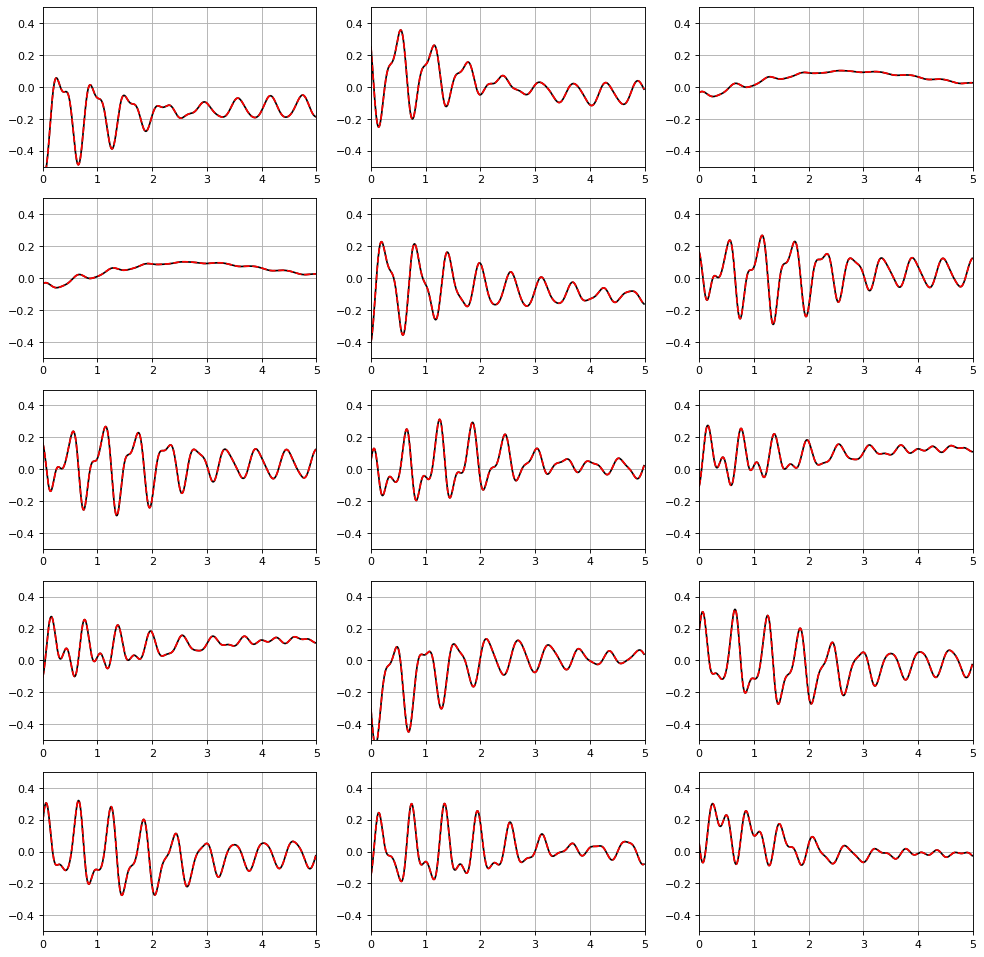

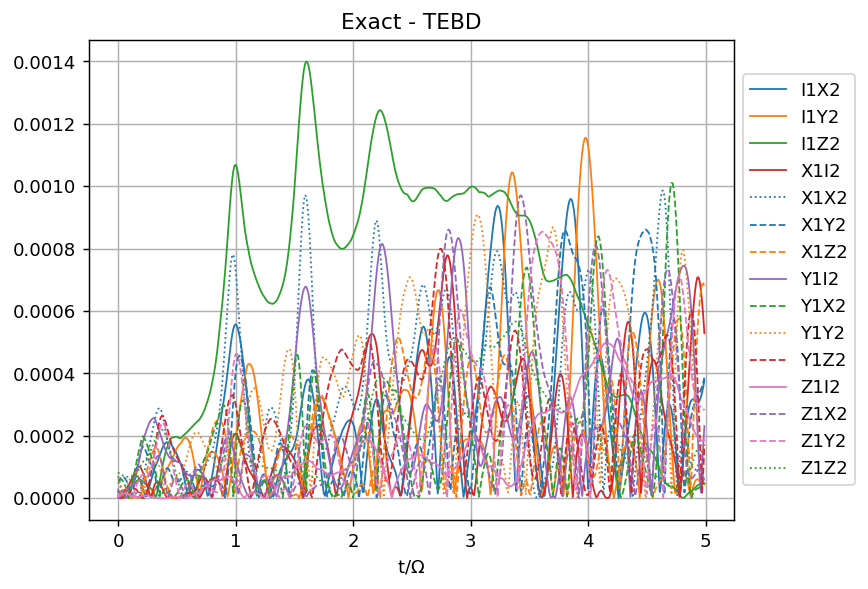

0.0013999804117443904
Building Hamiltonian for L=8
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=8 

Building the spin chain 

Imaginary time evolution 



t=0.5, max-bond=35: 100%|###################################################################################################################################| 100/100 [00:00<00:00, 188.49%/s]


Real time evolution


t=4.99, max-bond=48: 100%|##################################################################################################################################| 500/500 [01:50<00:00,  4.52it/s]


Time:110s


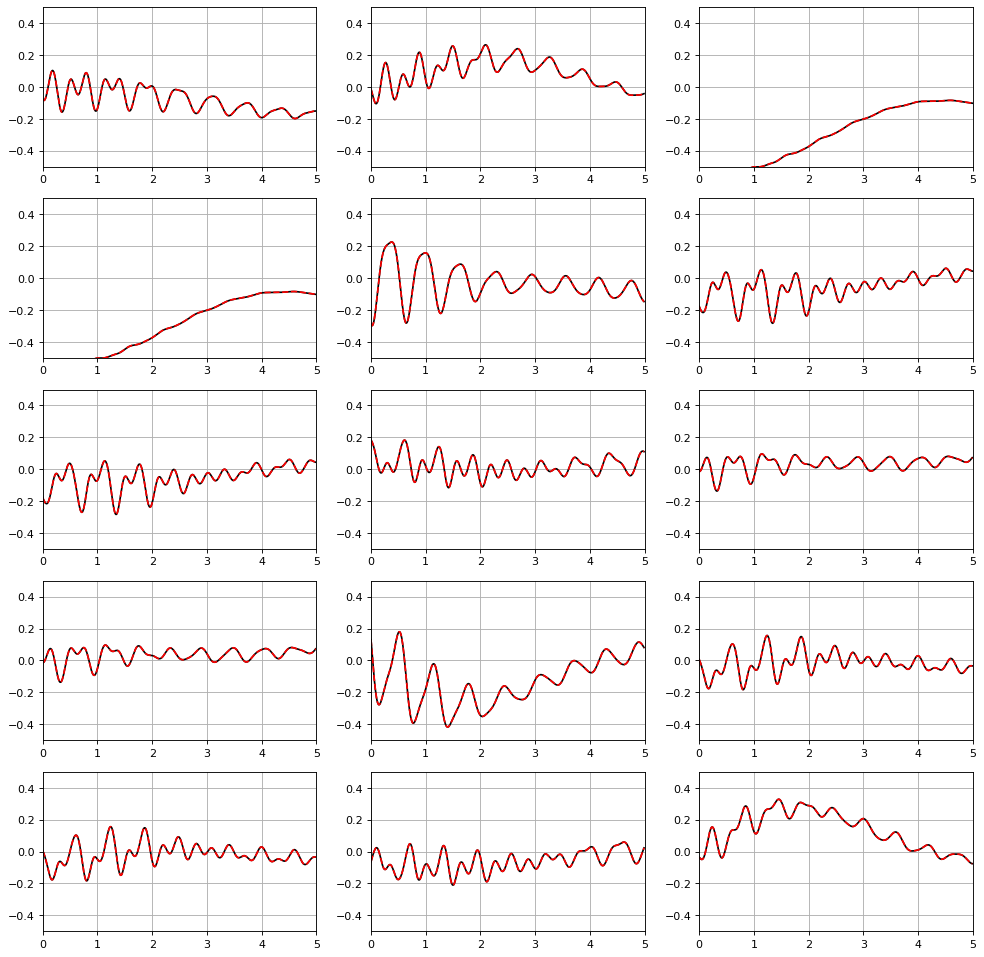

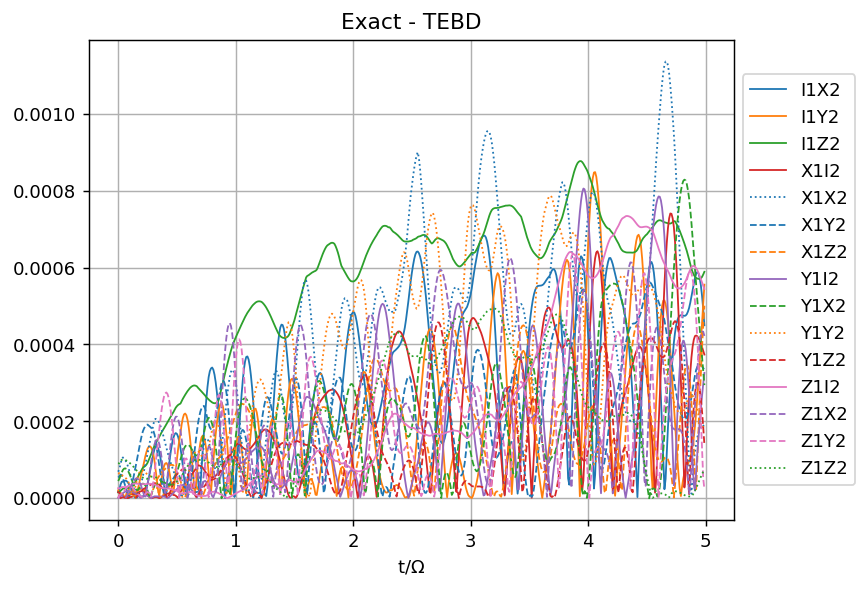

0.0012678332795171424
Building Hamiltonian for L=8
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=8 

Building the spin chain 

Imaginary time evolution 



t=0.5, max-bond=35: 100%|###################################################################################################################################| 100/100 [00:00<00:00, 174.88%/s]


Real time evolution


t=4.53, max-bond=44:  91%|#####################################################################################################################7            | 453/500 [01:30<00:09,  4.98it/s]


KeyboardInterrupt: 

In [4]:
err = 0

for i in range(5):
    err += calculate_error(L=8, omega=1, V=10, V_=10, beta=1, T=5, \
                    dt=0.01, re_cutoff=1e-5, img_cutoff=1e-10, tolerance=1e-3)
    print(err/(i+1))
print(f'Errore {err}')

In [27]:
err = 0
errore = {}
for N in [4,6,8]:
    err = 0
    for i in range(5):
        err += calculate_error(L=N, omega=1, V=10, V_=10, beta=0.1, T=10, \
                               dt=0.01, re_cutoff=1e-6, img_cutoff=1e-10, tolerance=1e-3)
    errore[str(N)] = err/5

Building Hamiltonian for L=4
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=4 

Building the spin chain 

Imaginary time evolution 



t=0.05, max-bond=10: 100%|#################################################################################################################################| 100/100 [00:00<00:00, 2387.97%/s]


Real time evolution


t=4.08, max-bond=106:  41%|####################################################3                                                                           | 409/1000 [01:43<02:30,  3.94it/s]


KeyboardInterrupt: 

In [4]:
err = 0
errore = {}
for re_cut in [1e-6, 1e-7, 1e-8, 1e-9]:
    err = 0
    for i in range(5):
        err += calculate_error(L=6, omega=1, V=0.5, V_=0.5, beta=1, T=10, \
                               dt=0.01, re_cutoff=re_cut, img_cutoff=1e-10, tolerance=1e-3)
    errore[str(re_cut)] = err/5

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.5, max-bond=15: 100%|###################################################################################################################################| 100/100 [00:00<00:00, 905.55%/s]


Real time evolution


t=2.52, max-bond=12:  25%|################################5                                                                                                | 252/1000 [00:13<00:38, 19.28it/s]


KeyboardInterrupt: 

In [6]:
errore

{'1e-06': 0.36255057409651104,
 '1e-07': 0.03493889499973461,
 '1e-08': 0.004204259301274193,
 '1e-09': 0.00031166441150357244}

In [11]:
table = np.empty([7,7])

for i in range(7):
    for j in range(7):
        print(f'i = {i}, j = {j} =====================================')
        avrg = 0
        for k in range(5):
            print(f'Simulation {(i*7 + j)*5 + k} / {7*7*5}')
            avrg += calculate_error(L, omega, V, V_, beta, T, dt, 10**(-2-i), 10**(-2-j), tolerance)
        table[i][j] = avrg/5


i = 0, j = 0 =====================================
Simulation 0 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath



KeyboardInterrupt: 

In [5]:
import pickle

with open('./table.pkl', 'wb') as f:
    pickle.dump(table, f, protocol=pickle.HIGHEST_PROTOCOL)


In [22]:
10**(-2)

0.01

Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.025, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6761.52%/s]


Real time evolution


t=9.9, max-bond=31: 100%|###################################################################################################################################################################################################| 100/100 [00:11<00:00,  8.82it/s]

Time:11s
Max error 0.01360096280276415


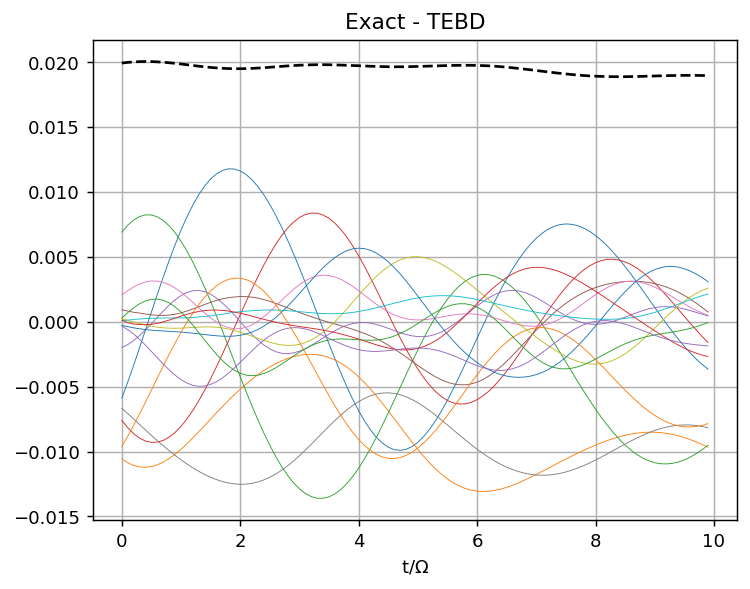

Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.025, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6778.56%/s]


Real time evolution


t=9.9, max-bond=31: 100%|###################################################################################################################################################################################################| 100/100 [00:11<00:00,  8.84it/s]

Time:11s
Max error 0.013565820092547415


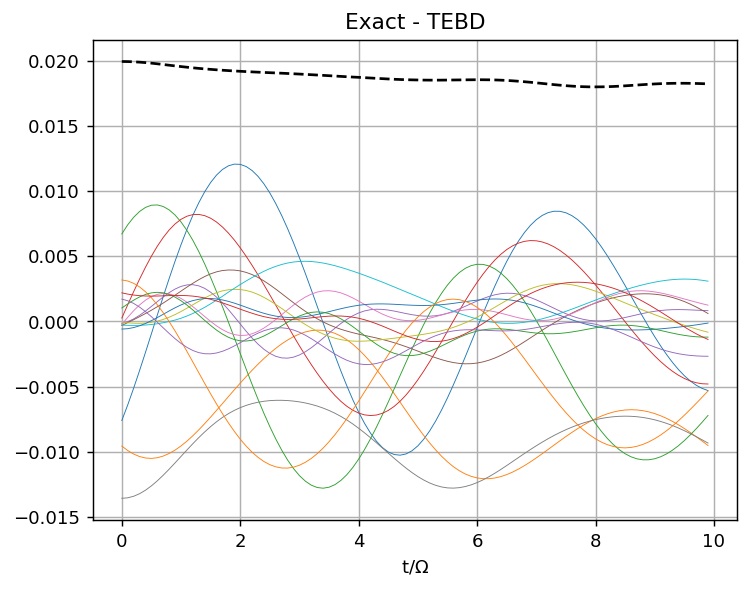

Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.025, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6979.11%/s]


Real time evolution


t=9.9, max-bond=31: 100%|###################################################################################################################################################################################################| 100/100 [00:11<00:00,  8.79it/s]

Time:11s
Max error 0.012921458300982003


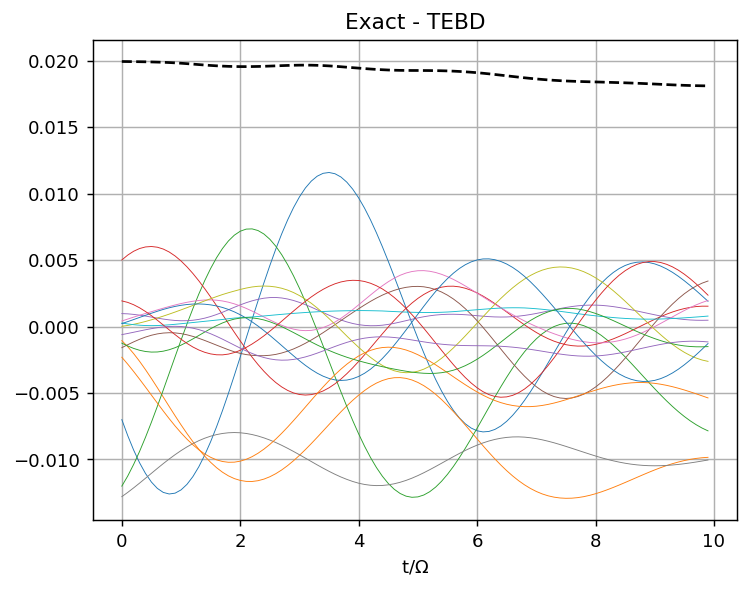

Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.025, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6749.44%/s]


Real time evolution


t=9.9, max-bond=31: 100%|###################################################################################################################################################################################################| 100/100 [00:11<00:00,  8.85it/s]

Time:11s
Max error 0.012976947697167574


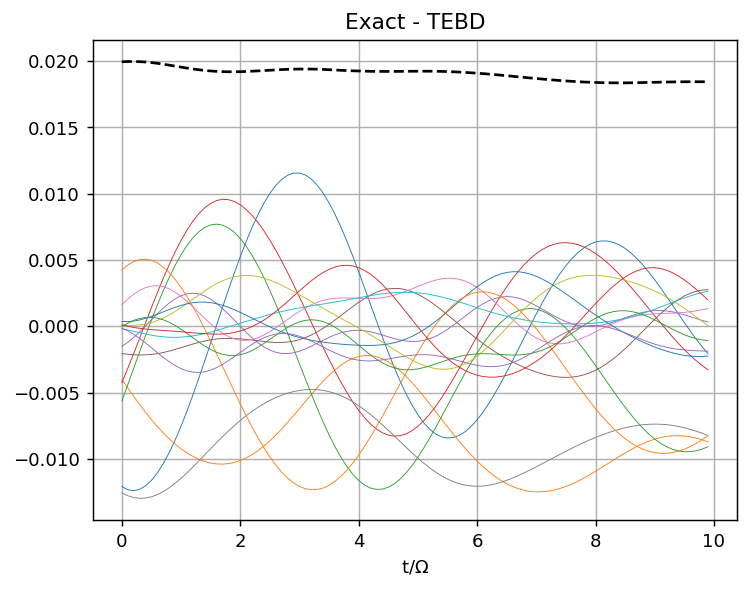

Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.025, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6910.92%/s]


Real time evolution


t=9.9, max-bond=31: 100%|###################################################################################################################################################################################################| 100/100 [00:11<00:00,  8.91it/s]

Time:11s
Max error 0.013872951991341432


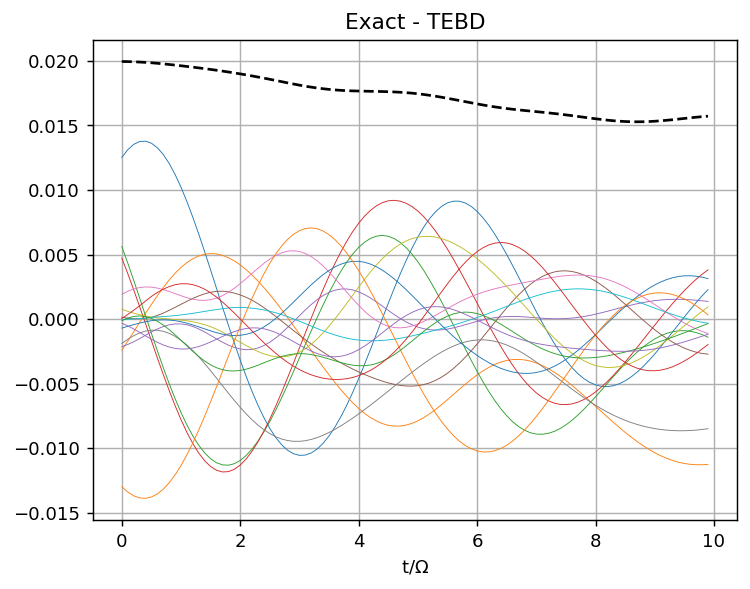

0.013387628176960514


In [18]:
avrg = 0
for k in range(5):
    #print(f'Simulation {(i*7 + j)*5 + k} / {7*7*5}')
    avrg += calculate_error(L, omega, V, V_, beta, T, dt, 10**(-5), 10**(-7), 1e-5)
print(avrg/5)

In [9]:
table

array([[0.00682243, 0.00552424, 0.00417139, 0.00419464, 0.00410984,
        0.00454527, 0.00388152],
       [0.05021028, 0.05022727, 0.02517097, 0.02550323, 0.02548311,
        0.02563907, 0.02567514],
       [0.00226081, 0.00218075, 0.00272002, 0.00269445, 0.00272258,
        0.00271166, 0.00279806],
       [0.00097657, 0.00104132, 0.00271437, 0.00265763, 0.00263804,
        0.00271124, 0.00269293],
       [0.0010118 , 0.00105415, 0.002701  , 0.00263098, 0.00266115,
        0.0026898 , 0.00265087],
       [0.00099997, 0.00095371, 0.00274505, 0.00266759, 0.00261055,
        0.00274643, 0.00263649],
       [0.00098992, 0.00096781, 0.0027409 , 0.00267565, 0.00260023,
        0.00273711, 0.00266997]])

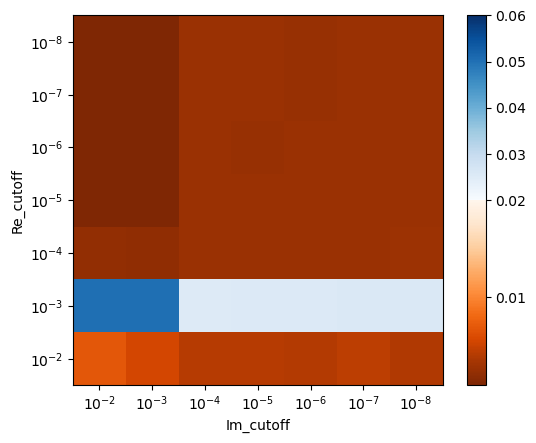

In [11]:
divnorm = mpl.colors.TwoSlopeNorm(vmin=0.001, vcenter=0.02, vmax=0.06)

top = plt.cm.get_cmap('Oranges_r', 128)
bottom = plt.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcm = mpl.colors.ListedColormap(newcolors, name='OrangeBlue')

fig, ax = plt.subplots()

im = ax.imshow(table, origin='lower', cmap=newcm, norm=divnorm)

my_ticks = [r'$10^{-2}$', r'$10^{-3}$', r'$10^{-4}$', r'$10^{-5}$', r'$10^{-6}$', r'$10^{-7}$', r'$10^{-8}$']
ax.set_xticks([i for i in range(7)])
ax.set_xticklabels(my_ticks)
ax.set_xlabel('Im_cutoff')
ax.set_yticks([i for i in range(7)])
ax.set_yticklabels(my_ticks)
ax.set_ylabel('Re_cutoff')

fig.colorbar(im, ax=ax)

fig = plt.gcf()
#plt.legend()
plt.show()

#fig.savefig('./pictures/error_study.pdf', dpi=150)